## Import libs, load and examine data

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns  

In [46]:
# load data and get some insight
pdata = pd.read_excel("data.xlsx")
pdata.head()

Sl_No  Customer Key  Avg_Credit_Limit  Total_Credit_Cards  \
0      1         87073            100000                   2   
1      2         38414             50000                   3   
2      3         17341             50000                   7   
3      4         40496             30000                   5   
4      5         47437            100000                   6   

   Total_visits_bank  Total_visits_online  Total_calls_made  
0                  1                    1                 0  
1                  0                   10                 9  
2                  1                    3                 4  
3                  1                    1                 4  
4                  0                   12                 3

## Perform  EDA

In [47]:
# Remove 0 and 1 indices since those are not needed
pdata.drop(pdata.columns[[0,1]], inplace=True, axis=1)
unique_values = pdata.nunique()
print('Count unique values in each column')
print(unique_values)

Count unique values in each column
Avg_Credit_Limit       110
Total_Credit_Cards      10
Total_visits_bank        6
Total_visits_online     16
Total_calls_made        11
dtype: int64


In [48]:
pdata.info

<bound method DataFrame.info of      Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
0              100000                   2                  1   
1               50000                   3                  0   
2               50000                   7                  1   
3               30000                   5                  1   
4              100000                   6                  0   
..                ...                 ...                ...   
655             99000                  10                  1   
656             84000                  10                  1   
657            145000                   8                  1   
658            172000                  10                  1   
659            167000                   9                  0   

     Total_visits_online  Total_calls_made  
0                      1                 0  
1                     10                 9  
2                      3                 4  
3                  

In [49]:
pdata.describe().transpose()

count          mean           std     min      25%  \
Avg_Credit_Limit     660.0  34574.242424  37625.487804  3000.0  10000.0   
Total_Credit_Cards   660.0      4.706061      2.167835     1.0      3.0   
Total_visits_bank    660.0      2.403030      1.631813     0.0      1.0   
Total_visits_online  660.0      2.606061      2.935724     0.0      1.0   
Total_calls_made     660.0      3.583333      2.865317     0.0      1.0   

                         50%      75%       max  
Avg_Credit_Limit     18000.0  48000.0  200000.0  
Total_Credit_Cards       5.0      6.0      10.0  
Total_visits_bank        2.0      4.0       5.0  
Total_visits_online      2.0      4.0      15.0  
Total_calls_made         3.0      5.0      10.0

In [50]:
print("Missing values:\n{}".format(pdata.isnull().sum()))

Missing values:
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64


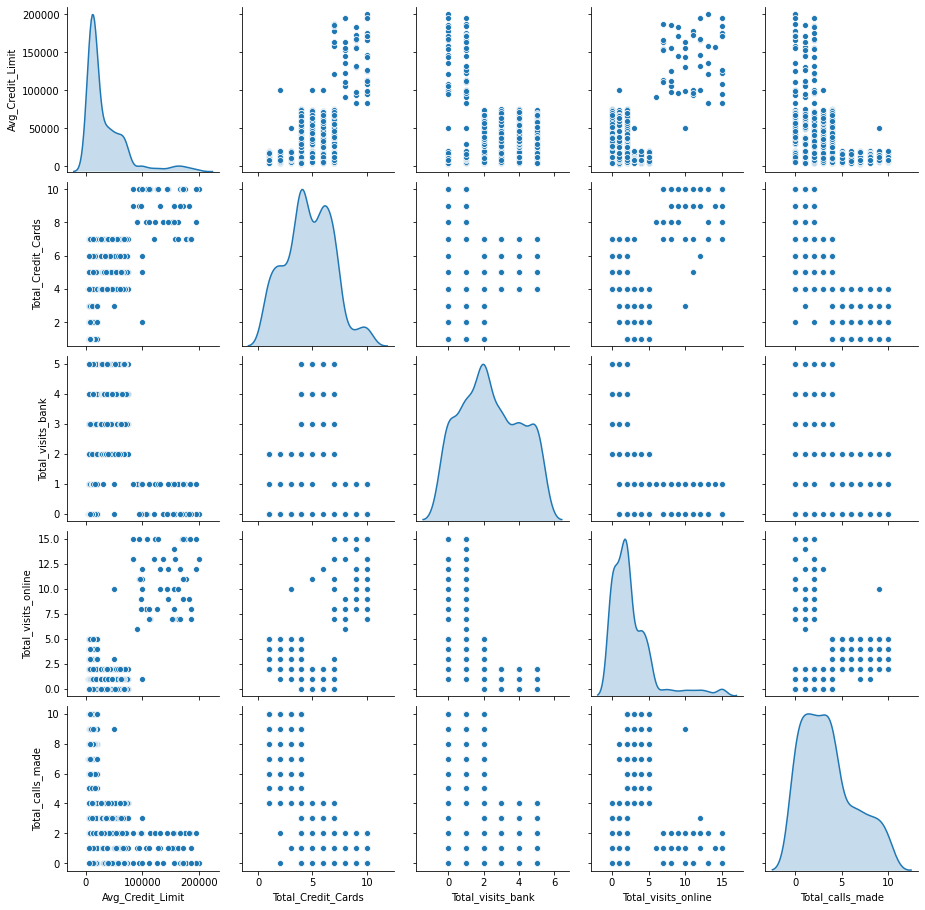

In [92]:
# Genarate pairplot to see multivariate 
sns.pairplot(pdata, diag_kind='kde') 

In [52]:
# Based on the kde plots above, we can work with 2 or 3 clusters
from scipy.stats import zscore
pdata_z = pdata.apply(zscore)

# KMean Clustering

Text(0.5, 1.0, 'Selecting k with the Elbow Method')

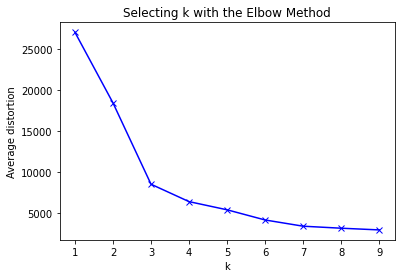

In [88]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
clusters=range(1,10)
meanDistortions=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(pdata)
    
    meanDistortions.append(sum(np.min(cdist(pdata, model.cluster_centers_, 'euclidean'), axis=1)) / pdata
                           .shape[0])
    
plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')

In [54]:
#Set the value of k=3 base on above elbow plot
kmeans = KMeans(n_clusters=3, n_init = 15, random_state=2345)

In [55]:
# Compute K-means clustering
kmeans.fit(pdata_z)

KMeans(n_clusters=3, n_init=15, random_state=2345)

In [107]:
centroids = kmeans.cluster_centers_


In [114]:
centroids
centroid_df = pd.DataFrame(centroids, columns = list(pdata_z) )
print(centroid_df)


ValueError: Shape of passed values is (3, 5), indices imply (3, 6)

In [117]:
# Calculate silhouette_avg for K-means clustering
silhouette_avg = silhouette_score(pdata_z, kmeans.labels_)
print("silhouette_avg for Kmeans is:{}".format(silhouette_avg))

silhouette_avg for Kmeans is:0.5892124802251283


In [118]:
# Cluster 0 has the lowest values and cluster 2 has the highest values
## creating a new dataframe only for labels and converting it into categorical variable
df_labels = pd.DataFrame(kmeans.labels_ , columns = list(['labels']))

df_labels['labels'] = df_labels['labels'].astype('category')

In [119]:
df_labeled = pdata.join(df_labels)
df_analysis = (df_labeled.groupby(['labels'] , axis=0)).head(4177)
df_analysis

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
0              100000                   2                  1   
1               50000                   3                  0   
2               50000                   7                  1   
3               30000                   5                  1   
4              100000                   6                  0   
..                ...                 ...                ...   
655             99000                  10                  1   
656             84000                  10                  1   
657            145000                   8                  1   
658            172000                  10                  1   
659            167000                   9                  0   

     Total_visits_online  Total_calls_made labels  
0                      1                 0      1  
1                     10                 9      0  
2                      3                 4      1  
3                      1                 4      1  
4                     12                 3      2  
..                   ...               ...    ...  
655                   10                 0      2  
656                   13                 2      2  
657                    9                 1      2  
658                   15                 0      2  
659                   12                 2      2  

[660 rows x 6 columns]

In [120]:
df_labeled['labels'].value_counts()  

1    386
0    224
2     50
Name: labels, dtype: int64

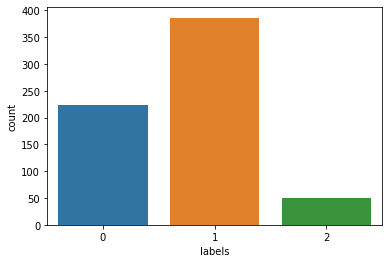

In [121]:
cluster_count = sns.countplot(x="labels", data=df_analysis)

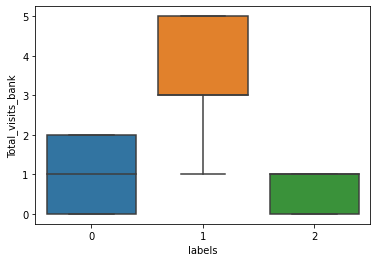

In [122]:
# Box plot to visualize Cluster Id vs Total visit bank
sns.boxplot(x='labels', y='Total_visits_bank', data=df_analysis)

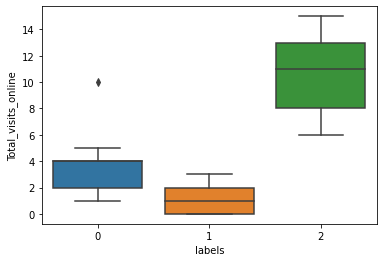

In [123]:
# Box plot to visualize Cluster Id vs Total visit online
sns.boxplot(x='labels', y='Total_visits_online', data=df_analysis)

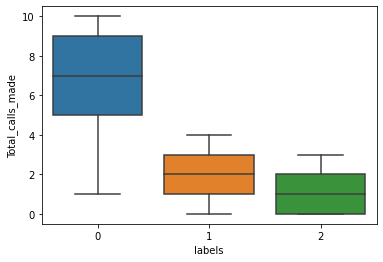

In [124]:
# Box plot to visualize Cluster Id vs Total call made
sns.boxplot(x='labels', y='Total_calls_made', data=df_analysis)

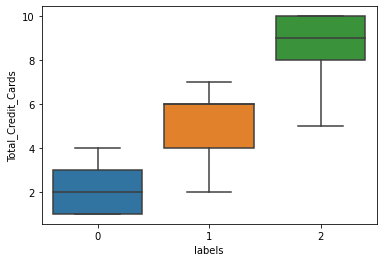

In [125]:
sns.boxplot(x='labels', y='Total_Credit_Cards', data=df_analysis)

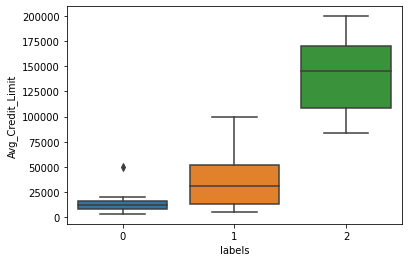

In [126]:
sns.boxplot(x='labels', y='Avg_Credit_Limit', data=df_analysis)

Base on boxplot above we can identify 3 segment groups of customers.

1. Group 0: Customers who have low average credit limit and low credit cards tend to make more phone calls than visit online or go to the bank.

2. Group 1: Customers who have average credit limit (up to 100k) make less phone call, less visit online from group 0, and go to the bank the most. This is also most of the bank's customers belong to this group.

3. Group 2: Customers who have the highest credit limit, make the least phone calls and go to the bank less than other 2 groups above but using online the most

# Hierachy Clustering

In [127]:
from sklearn.cluster import AgglomerativeClustering

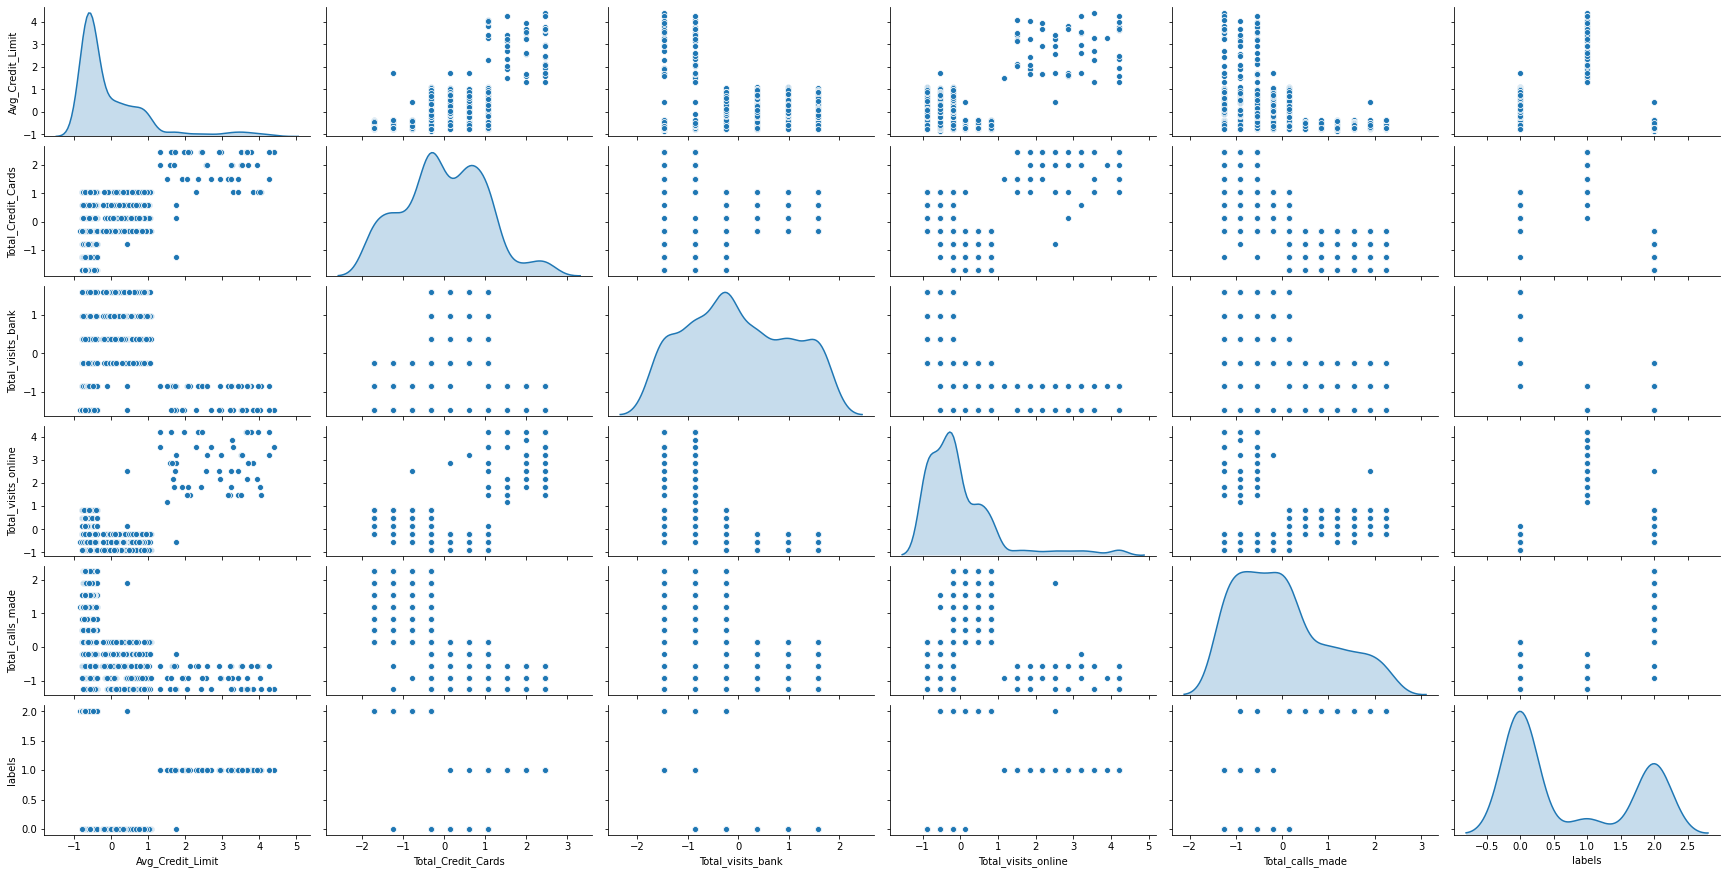

In [106]:
sns.pairplot(pdata_z, height=2,aspect=2 , diag_kind='kde')

In [108]:
model = AgglomerativeClustering(n_clusters=3, affinity='euclidean',  linkage='average')

In [109]:
model.fit(pdata_z)

AgglomerativeClustering(linkage='average', n_clusters=3)

In [110]:
pdata_z['labels'] = model.labels_
pdata_z.head(10)

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
0          1.740187           -1.249225          -0.860451   
1          0.410293           -0.787585          -1.473731   
2          0.410293            1.058973          -0.860451   
3         -0.121665            0.135694          -0.860451   
4          1.740187            0.597334          -1.473731   
5         -0.387644           -0.787585          -1.473731   
6          1.740187            0.135694          -1.473731   
7         -0.520633           -0.787585          -1.473731   
8         -0.786612           -1.249225          -1.473731   
9         -0.839808           -0.325946          -1.473731   

   Total_visits_online  Total_calls_made  labels  
0            -0.547490         -1.251537       0  
1             2.520519          1.891859       2  
2             0.134290          0.145528       0  
3            -0.547490          0.145528       0  
4             3.202298         -0.203739       1  
5            -0.547490          1.542593       2  
6             2.861408         -0.553005       1  
7            -0.547490         -0.902271       2  
8            -0.206600         -0.553005       2  
9            -0.547490          1.193326       2

In [111]:
# Pairwise distribution between data points
from scipy.spatial.distance import pdist 
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage

In [112]:
# cophenet index is a measure of the correlation between the distance of points in feature space and distance on dendrogram
# closer it is to 1, the better is the clustering

Z = linkage(pdata_z, metric='euclidean', method='average')
c, coph_dists = cophenet(Z , pdist(pdata_z))
c

0.9252387749820263

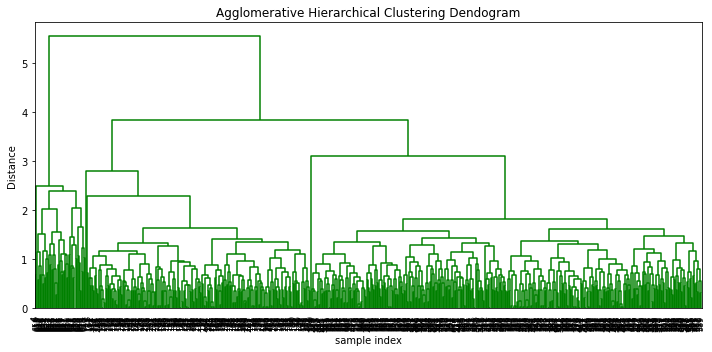

In [113]:
plt.figure(figsize=(10, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation=90.,color_threshold = 40, leaf_font_size=8. )
plt.tight_layout()

In [ ]:
# closer it is to 1, the better is the clustering

Z = linkage(pdata_z, metric='euclidean', method='complete')
c, coph_dists = cophenet(Z , pdist(pdata_z))
c

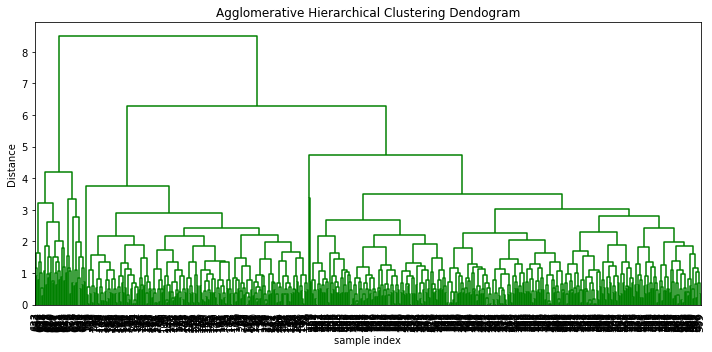

In [116]:
plt.figure(figsize=(10, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation=90.,color_threshold=90,  leaf_font_size=10. )
plt.tight_layout()